Just setting the environment up, assuming all module have been installed prior.

In [1]:
import requests, json, time, pathlib, yaml
import pandas as pd
import matplotlib.pyplot as plt 
#from cli_badges import badge

Function that gets the share price from alphavantage

In [2]:
def RealTimeSharePrice (stock_symbol, api_key) :
    '''This function loads the current shareprice from alphavantage'''
    base_url = "https://www.alphavantage.co/query?function=GLOBAL_QUOTE"
    main_url = base_url + "&symbol=" + stock_symbol + "&apikey=" + api_key
    req_ob = requests.get(main_url)                     #get method of requests module & return response object
    result = req_ob.json()                              #json method return json format data into python dictionary data typ & result contains list of nested dictionaries
    if debug == True : 
        print("Result before parsing the json data :\n", result)
        print("Parsed as :\n", result["Global Quote"])
        print("Lenght ", len(result["Global Quote"]))
    if len(result["Global Quote"]) > 0: 
        share_price = float(result["Global Quote"]['05. price'])
        share_change = float(result["Global Quote"]["09. change"])
        if share_change >= 0 :
            messagebg = 'green'
        else :
            messagebg = 'red'
        label = result["Global Quote"]["01. symbol"]
        price = result["Global Quote"]["05. price"]
        change = result["Global Quote"]["09. change"]
        #PriceBadge = badge(label, price, messagebg='blue',messagecolor='black')
        #ChangeBadge = badge(label, change, messagebg=messagebg, messagecolor='black')
        #print(PriceBadge, ChangeBadge, "\n")
        print(f"Realtime share price for {label}: price: {price}, change : {change}")
    else:
        share_price = float(0)
    return(share_price)

Functions to get and plot the IntraDayPrice

In [3]:
def IntraDayPrice (stock_symbol, api_key) :
    '''This function loas the intraday data from alphavantage with 5 min gaps'''
    base_url = "https://www.alphavantage.co/query?function=TIME_SERIES_INTRADAY"
    main_url = base_url + "&symbol=" + stock_symbol + "&interval=5min" + "&apikey=" + api_key
    req_ob = requests.get(main_url)                     #get method of requests module & return response object
    result = req_ob.json()                              #json method return json format data into python dictionary data typ & result contains list of nested dictionaries
    idp_df=pd.DataFrame.from_dict(result['Time Series (5min)'], orient="index")  # json to df       
    idp_df.index = pd.to_datetime(idp_df.index, format='%Y-%m-%d')           #https://stackoverflow.com/questions/47124440/build-pandas-dataframe-from-json-data#47560590
    idp_df.index.name = 'Date'  
    idp_df['1. open'] = idp_df['1. open'].astype(float)
    idp_df['2. high'] = idp_df['2. high'].astype(float)
    idp_df['3. low'] = idp_df['3. low'].astype(float)
    idp_df['4. close'] = idp_df['4. close'].astype(float) 
    idp_df['5. volume'] = idp_df['5. volume'].astype(float) 
    if debug == True : 
        print(idp_df[['1. open', '4. close', '5. volume']])
    return(idp_df)

In [4]:
def PlotIntraDayPrice (stock_symbol, idp_df) :
    '''This function loads the intra day graph'''
    fig2, ax2 = plt.subplots(nrows=1, ncols=2, figsize=(12,5))
    title1 = "Intraday price " + stock_symbol
    title2 = "Intraday volume " + stock_symbol
    fig2.canvas.set_window_title(title1)
    idp_df.plot(ax=ax2[0], kind='line', use_index=True, y=['4. close'], title=title1, label=[stock_symbol])
    idp_df.plot(ax=ax2[1], kind='line', use_index=True, y=['5. volume'], title=title2, label=[stock_symbol])
    plt.subplots_adjust(bottom=0.15, left=0.05, right=0.85, top=0.95)
    if copy_to_file == True : SaveFig(fig2, stock_symbol + '_day')
    return()

Functions to get and plot the Historic Share Price

In [5]:
def HistoricSharePrice (stock_symbol, api_key) :
    '''This function loads the historic monthly shareprice from alphavantage'''
    base_url = "https://www.alphavantage.co/query?function=TIME_SERIES_MONTHLY"
    main_url = base_url + "&symbol=" + stock_symbol + "&apikey=" + api_key
    req_ob = requests.get(main_url)                     #get method of requests module & return response object
    result = req_ob.json()                              #json method return json format data into python dictionary data typ & result contains list of nested dictionaries
    hsp_df=pd.DataFrame.from_dict(result['Monthly Time Series'], orient="index")  # json to df       
    hsp_df.index = pd.to_datetime(hsp_df.index, format='%Y-%m-%d')           #https://stackoverflow.com/questions/47124440/build-pandas-dataframe-from-json-data#47560590
    hsp_df.index.name = 'Date'
    hsp_df['1. open'] = hsp_df['1. open'].astype(float)
    hsp_df['2. high'] = hsp_df['2. high'].astype(float)
    hsp_df['3. low'] = hsp_df['3. low'].astype(float)
    hsp_df['4. close'] = hsp_df['4. close'].astype(float)
    hsp_df['5. volume'] = hsp_df['5. volume'].astype(float) 
    if debug == True : 
        print(hsp_df[['1. open', '4. close']])
    return(hsp_df)

In [6]:
def PlotHistoricSharePrice (stock_symbol, hsp_df) :
    '''This function plots the historic monthly shareprice'''
    fig1, ax1 = plt.subplots(nrows=1, ncols=2, figsize=(12,5))
    hsp_df_12 = hsp_df[:12]
    title1 = "Historic monthly share price " + stock_symbol
    title2 = "Monthly share price for last year " + stock_symbol
    fig1.canvas.set_window_title(title1)
    hsp_df.plot(ax=ax1[0], kind='line', use_index=True, y=['4. close'], title=title1 , label=[stock_symbol])
    hsp_df_12.plot(ax=ax1[1], kind='line', use_index=True, y=['4. close'], title=title2, label=[stock_symbol])
    plt.subplots_adjust(bottom=0.15, left=0.05, right=0.85, top=0.95)
    if copy_to_file == True : SaveFig(fig1, stock_symbol + '_history')
    return()

Helper functions for 
1) saving the plot
2) ask the share code
3) process yaml settings


In [7]:
def SaveFig(fig, name) :
    '''This function saves the fig using a timestamp & name parameters'''
    path = pathlib.Path.cwd() / "png"
    name = time.strftime("%Y%m%d-%H%M%S") + '_' + name + '.png'
    if debug == True : print (name)
    fig.savefig(os.path.join(path, name))
    return()

In [8]:
def AskInputShareCode (): 
    stock_symbol =input("Please enter stock symbol to test on AlphaVantage :")
    return (stock_symbol)

In [9]:
def ProcessYAML (yaml_file) :
    '''This function opens the yaml file and returns the data object'''
    with open(yaml_file) as f:
        y_data = yaml.load(f, Loader=yaml.FullLoader)
        debug = y_data['debug']
        if debug == True : print("YAML file:\n", y_data)
    return (y_data)    

Main function


Realtime share price for AAPL: price: 499.2300, change : -0.8100


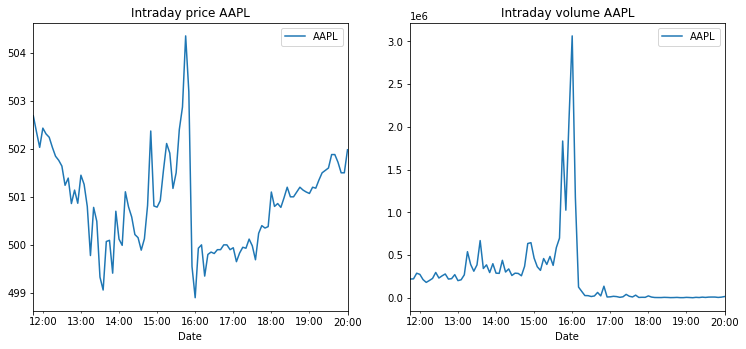

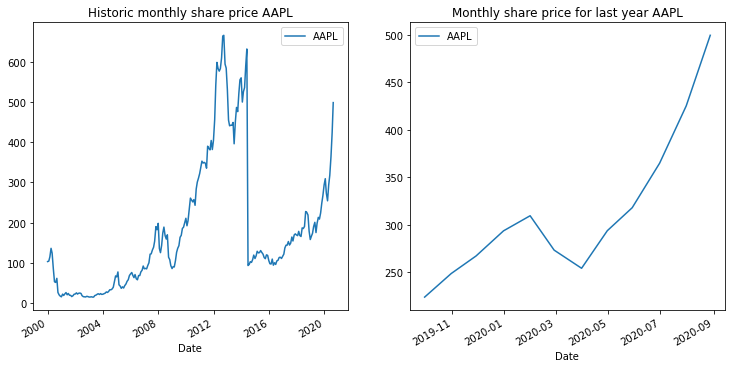

In [10]:
yaml_data = ProcessYAML('alpha.yaml')                                     #yaml settings are global variables
debug = yaml_data['debug']                                                #debug mode?
plot = yaml_data['plot']                                                  #plot mode?  
copy_to_file = yaml_data['copy_to_file']                                  #file output
api_key = yaml_data['api_key_dev']
stock_symbol = AskInputShareCode() 
if debug == True : print (api_key)
share_price = RealTimeSharePrice(stock_symbol, api_key)
intra_day_price_df = IntraDayPrice( stock_symbol, api_key)
hist_share_price_df = HistoricSharePrice (stock_symbol, api_key)
if plot == True : 
    PlotIntraDayPrice(stock_symbol, intra_day_price_df)
    PlotHistoricSharePrice(stock_symbol, hist_share_price_df)
    plt.show()
print("===========")

This is a good spot to run all cells above. it will ask for a share code, look up real time price and value and save the plots in the <png> directory.

===

Also a good spot to run all cells below: clean all output produce up when no lonbger needed.


In [2]:
import os 
import pathlib
from os import listdir
folder_path = pathlib.Path.cwd() / 'png'
for file_name in listdir(folder_path):
    file_path = os.path.join(folder_path, file_name)
    if file_name.endswith('.png'):
        os.remove(file_path)